In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from string import punctuation
from sklearn import svm
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from nltk import ngrams
from itertools import chain
import string
import re
from nltk.corpus import stopwords
stopwords=stopwords.words('english')
from nltk.stem.wordnet import WordNetLemmatizer
lemma = WordNetLemmatizer()
from wordcloud import WordCloud, STOPWORDS 



import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [2]:
positive_data = pd.read_excel('AmazonData.xlsx', sheet_name='Positive')
negative_data = pd.read_excel('AmazonData.xlsx', sheet_name='Negative')

#add classes to data
positive_data['class']=int(1)
negative_data['class']=int(0)

#make one dataset for all data
data= positive_data.copy()
data=data.append(negative_data, ignore_index = True)

In [5]:
print(positive_data.shape)
print(negative_data.shape)
print(data.shape)

(1590, 8)
(1530, 8)
(3120, 8)


In [9]:
#convert rating to numbers
data['Rating']= [i.split(' out', 1)[0] for i in data['Rating']]
data['Rating']=pd.to_numeric(data['Rating'])

data['Date']=pd.to_datetime(data['Date'])
data.columns

Index(['Profile URL', 'Profile Name', 'Rating', 'Review Title', 'Date',
       'Full Review', 'Color', 'class'],
      dtype='object')

In [39]:
pos_data= data.sort_values(['Rating','Date'], ascending=[False, False])
pos_data[['Profile Name','Rating','Date']].head()

,Profile Name,Rating,Date
1007,Tammy Matchett,5.0,2020-03-17
1384,Barbara D,5.0,2020-03-16
1506,KTC,5.0,2020-03-13
498,Overcomer98,5.0,2020-03-12
866,Wayne,5.0,2020-03-11


In [38]:
neg_data= data.sort_values(['Rating','Date'], ascending=[True, False])
neg_data[['Profile Name','Rating','Date']].head()

,Profile Name,Rating,Date
2446,Michael,1.0,2020-03-15
2020,scott11699,1.0,2020-03-11
2667,Helen,1.0,2020-03-11
2165,Robert McKnight,1.0,2020-03-08
2499,duck,1.0,2020-03-05


In [34]:
pos_data.head(10).iplot(
    x='Rating',
    y='Profile Name',
    xTitle='Rating',
    yTitle='Profile Name',
    mode='markers',
    title='The latest top rating profiles')

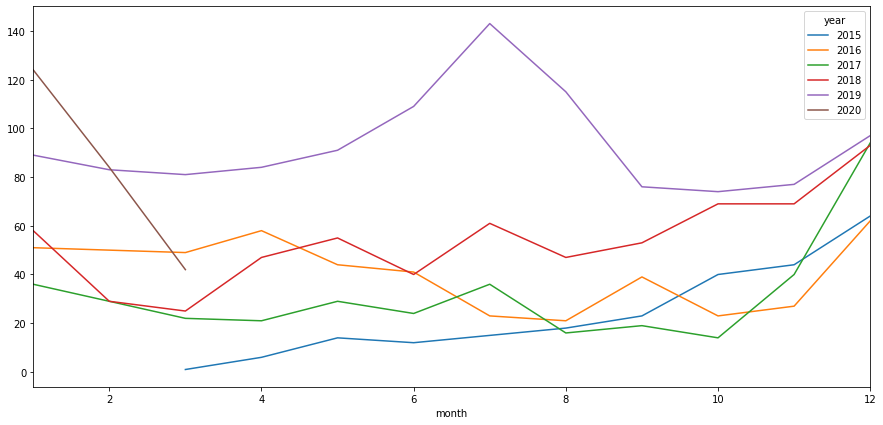

In [55]:
#Rating during mounth of years
p_df = data[['Rating','Date']]
p_df['month']=pd.DatetimeIndex(p_df['Date']).month
p_df['year']=pd.DatetimeIndex(p_df['Date']).year
p_df['month_year'] = pd.to_datetime(p_df['Date']).dt.to_period('M')
fig, ax = plt.subplots(figsize=(15,7))
p_df.groupby(['month','year']).count()['Rating'].unstack().plot(ax=ax)

In [11]:
# function for text cleaning 
def clean_text(text): 
    text=re.sub(r'[^\w\s]', '', text.lower()).replace("  ", " ").replace("\n", "")
    text=" ".join(lemma.lemmatize(word.strip()) for word in text.split() if word not in stopwords ) 
    text=" ".join(word for word in text.split() if word not in stopwords)
    return text

data['clean_Review'] = data['Full Review'].apply(lambda x: clean_text(x))
positive_data['clean_Review'] = positive_data['Full Review'].apply(lambda x: clean_text(x))
negative_data['clean_Review'] = negative_data['Full Review'].apply(lambda x: clean_text(x))
data['word_count']= data['clean_Review'].apply(lambda x: len(str(x).split()))
positive_data['word_count'] = positive_data['clean_Review'].apply(lambda x: len(str(x).split()))
negative_data['word_count'] = negative_data['clean_Review'].apply(lambda x: len(str(x).split()))

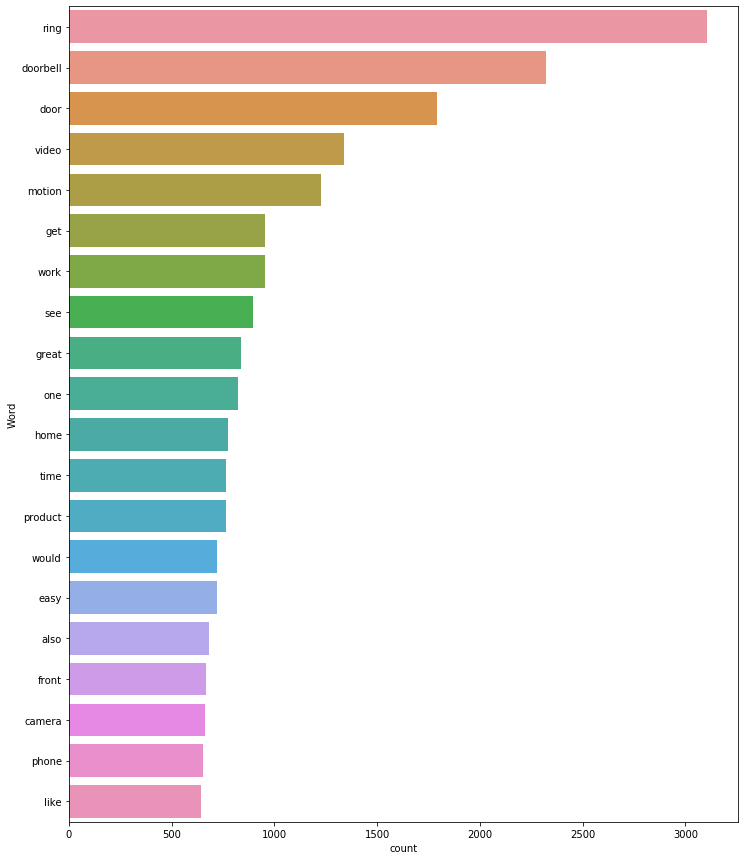

In [12]:
#The function below will visualize the words and their frequency 
def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()
  
# print 20 most frequent words 
freq_words(positive_data['clean_Review'], 20)


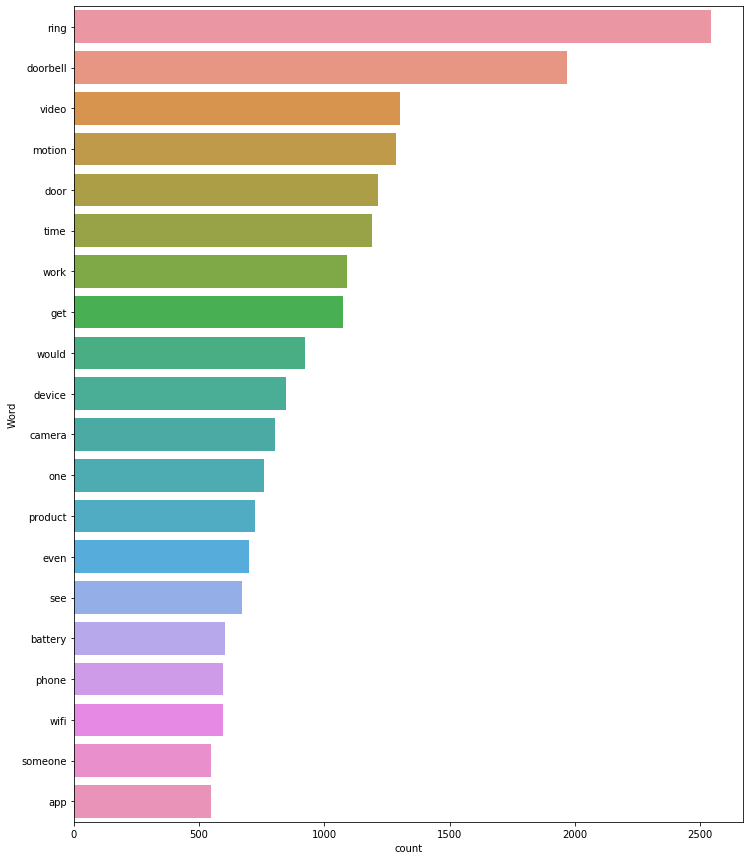

In [13]:
# print 20 most frequent words 
freq_words(negative_data['clean_Review'], 20)

In [14]:
#The distribution of review ratings
data['Rating'].iplot(
    kind='hist',
    xTitle='rating',
    linecolor='black',
    yTitle='count',
    title='Review Rating Distribution')

In [15]:
#Review Text Word Count Distribution
data['word_count'].iplot(
    kind='hist',
    bins=150,
    xTitle='word count',
    linecolor='black',
    yTitle='count',
    title='Review Text Word Count Distribution')

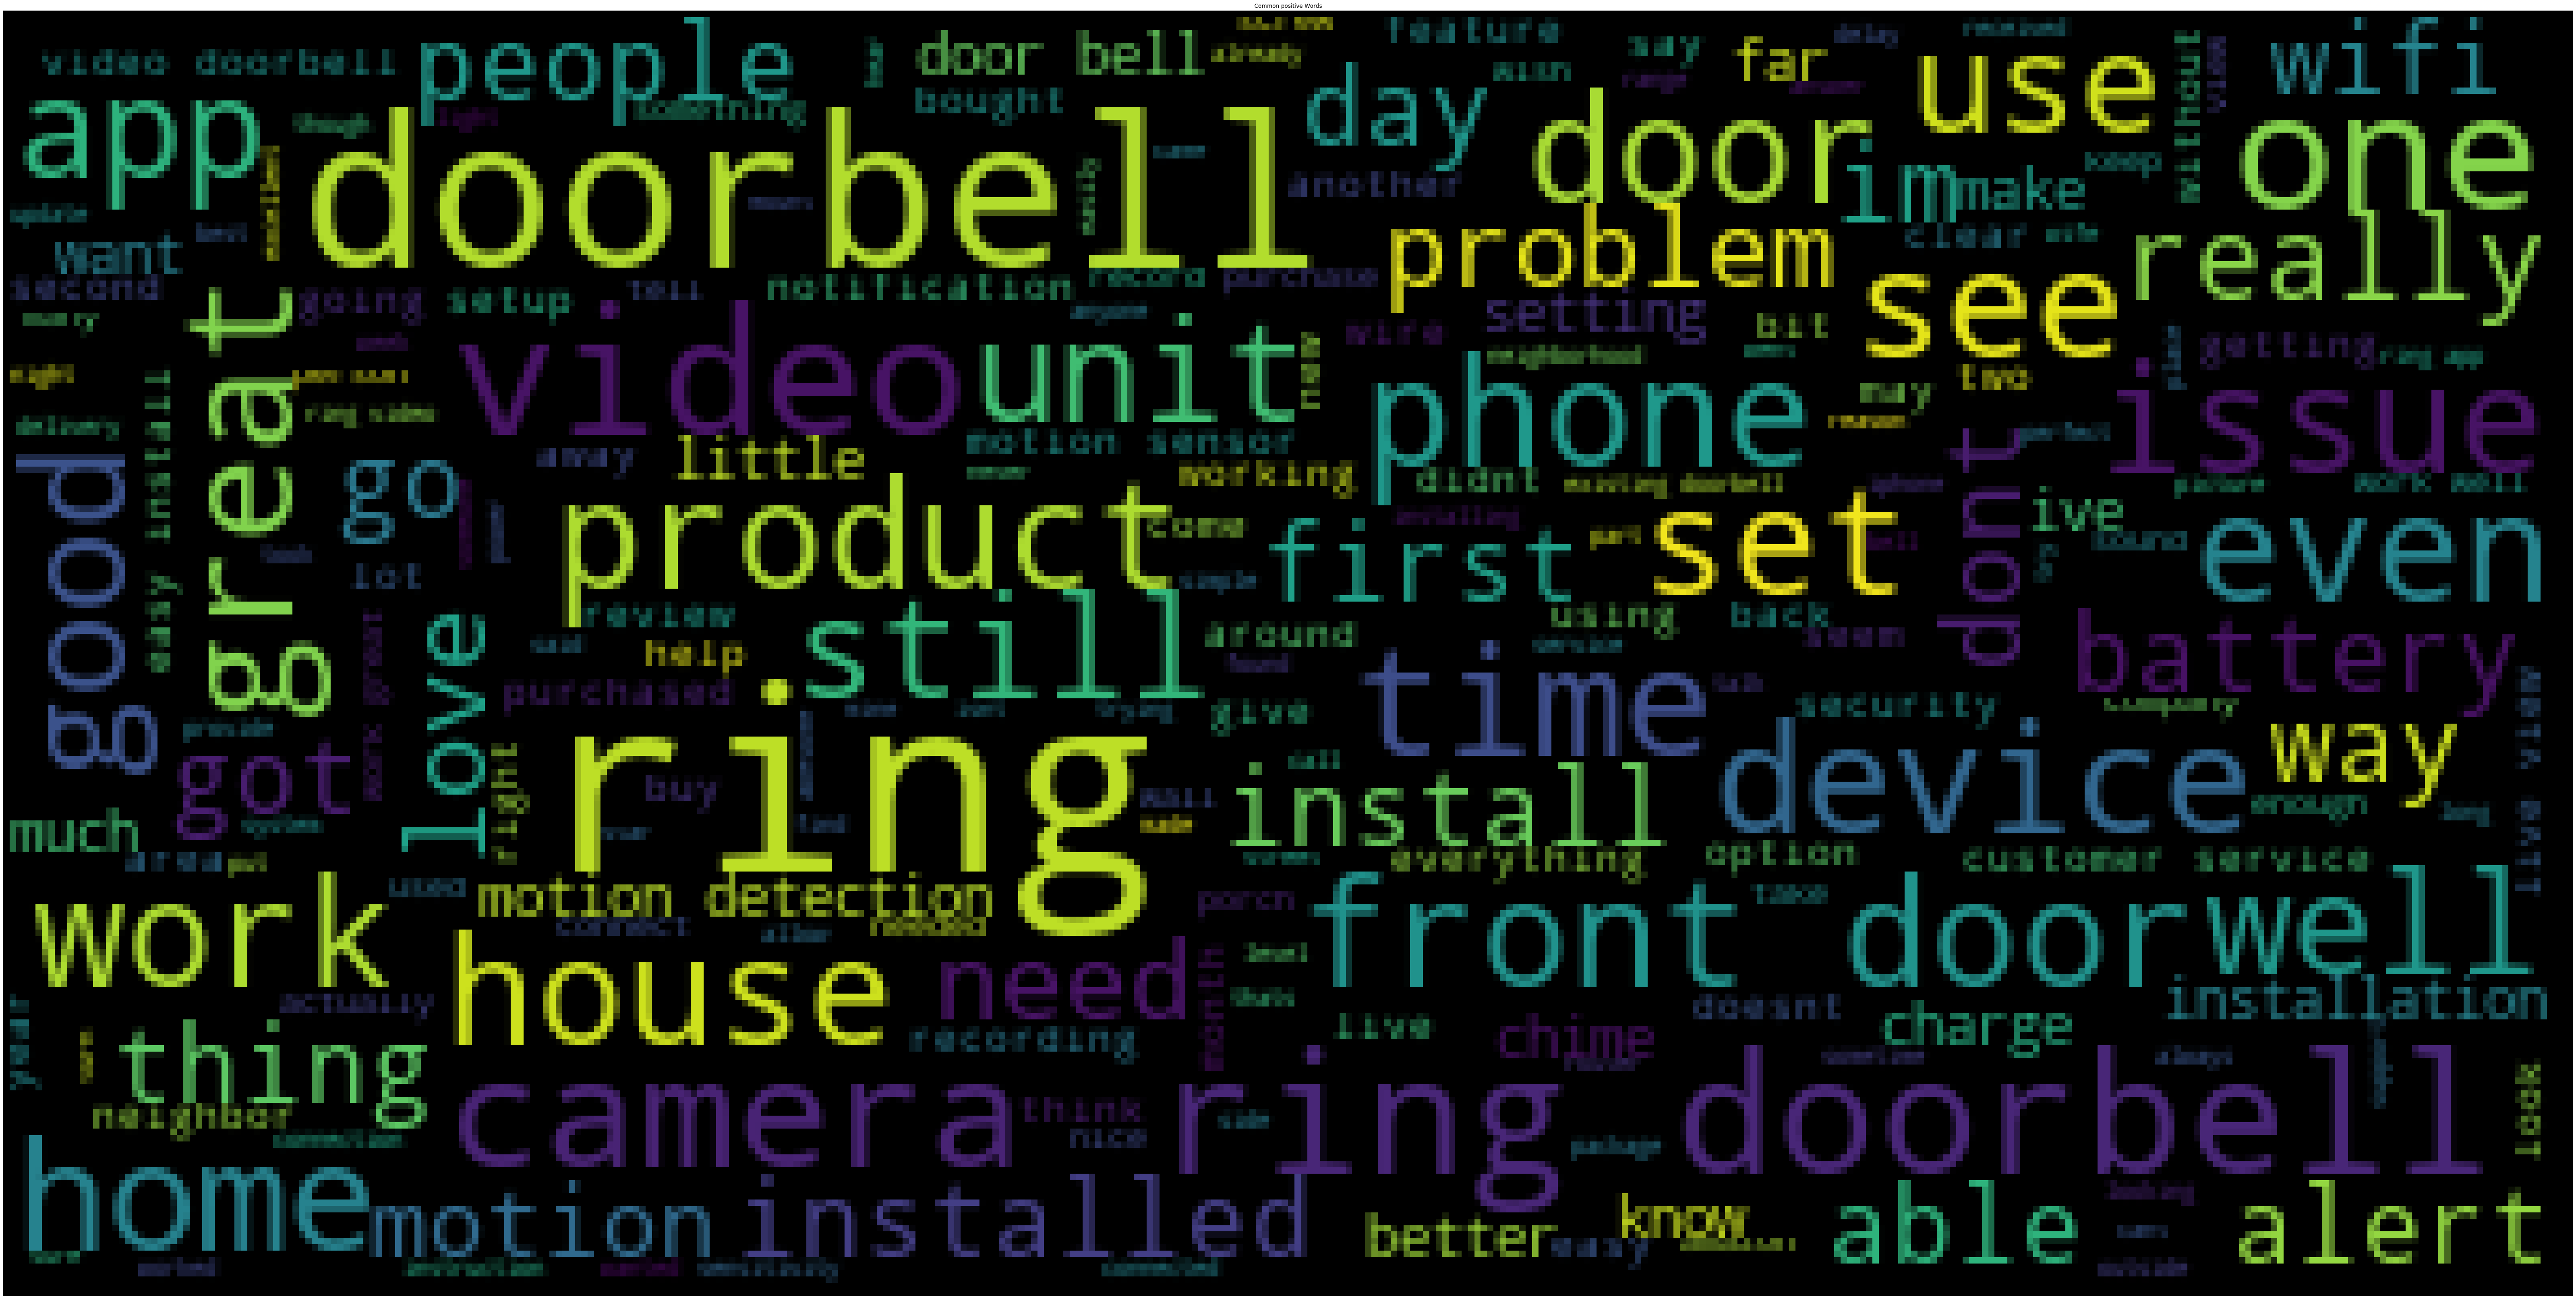

In [16]:
#commen words
def wc(data,title):
    plt.figure(figsize = (100,100))
    wc = WordCloud(background_color = 'black', max_words = 800,  
                   max_font_size = 40)
    wc.generate(' '.join(data))
    plt.title(title)
    plt.imshow(wc)
    plt.axis('off')

#Common positive Words
wc(positive_data['clean_Review'],'Common positive Words' )

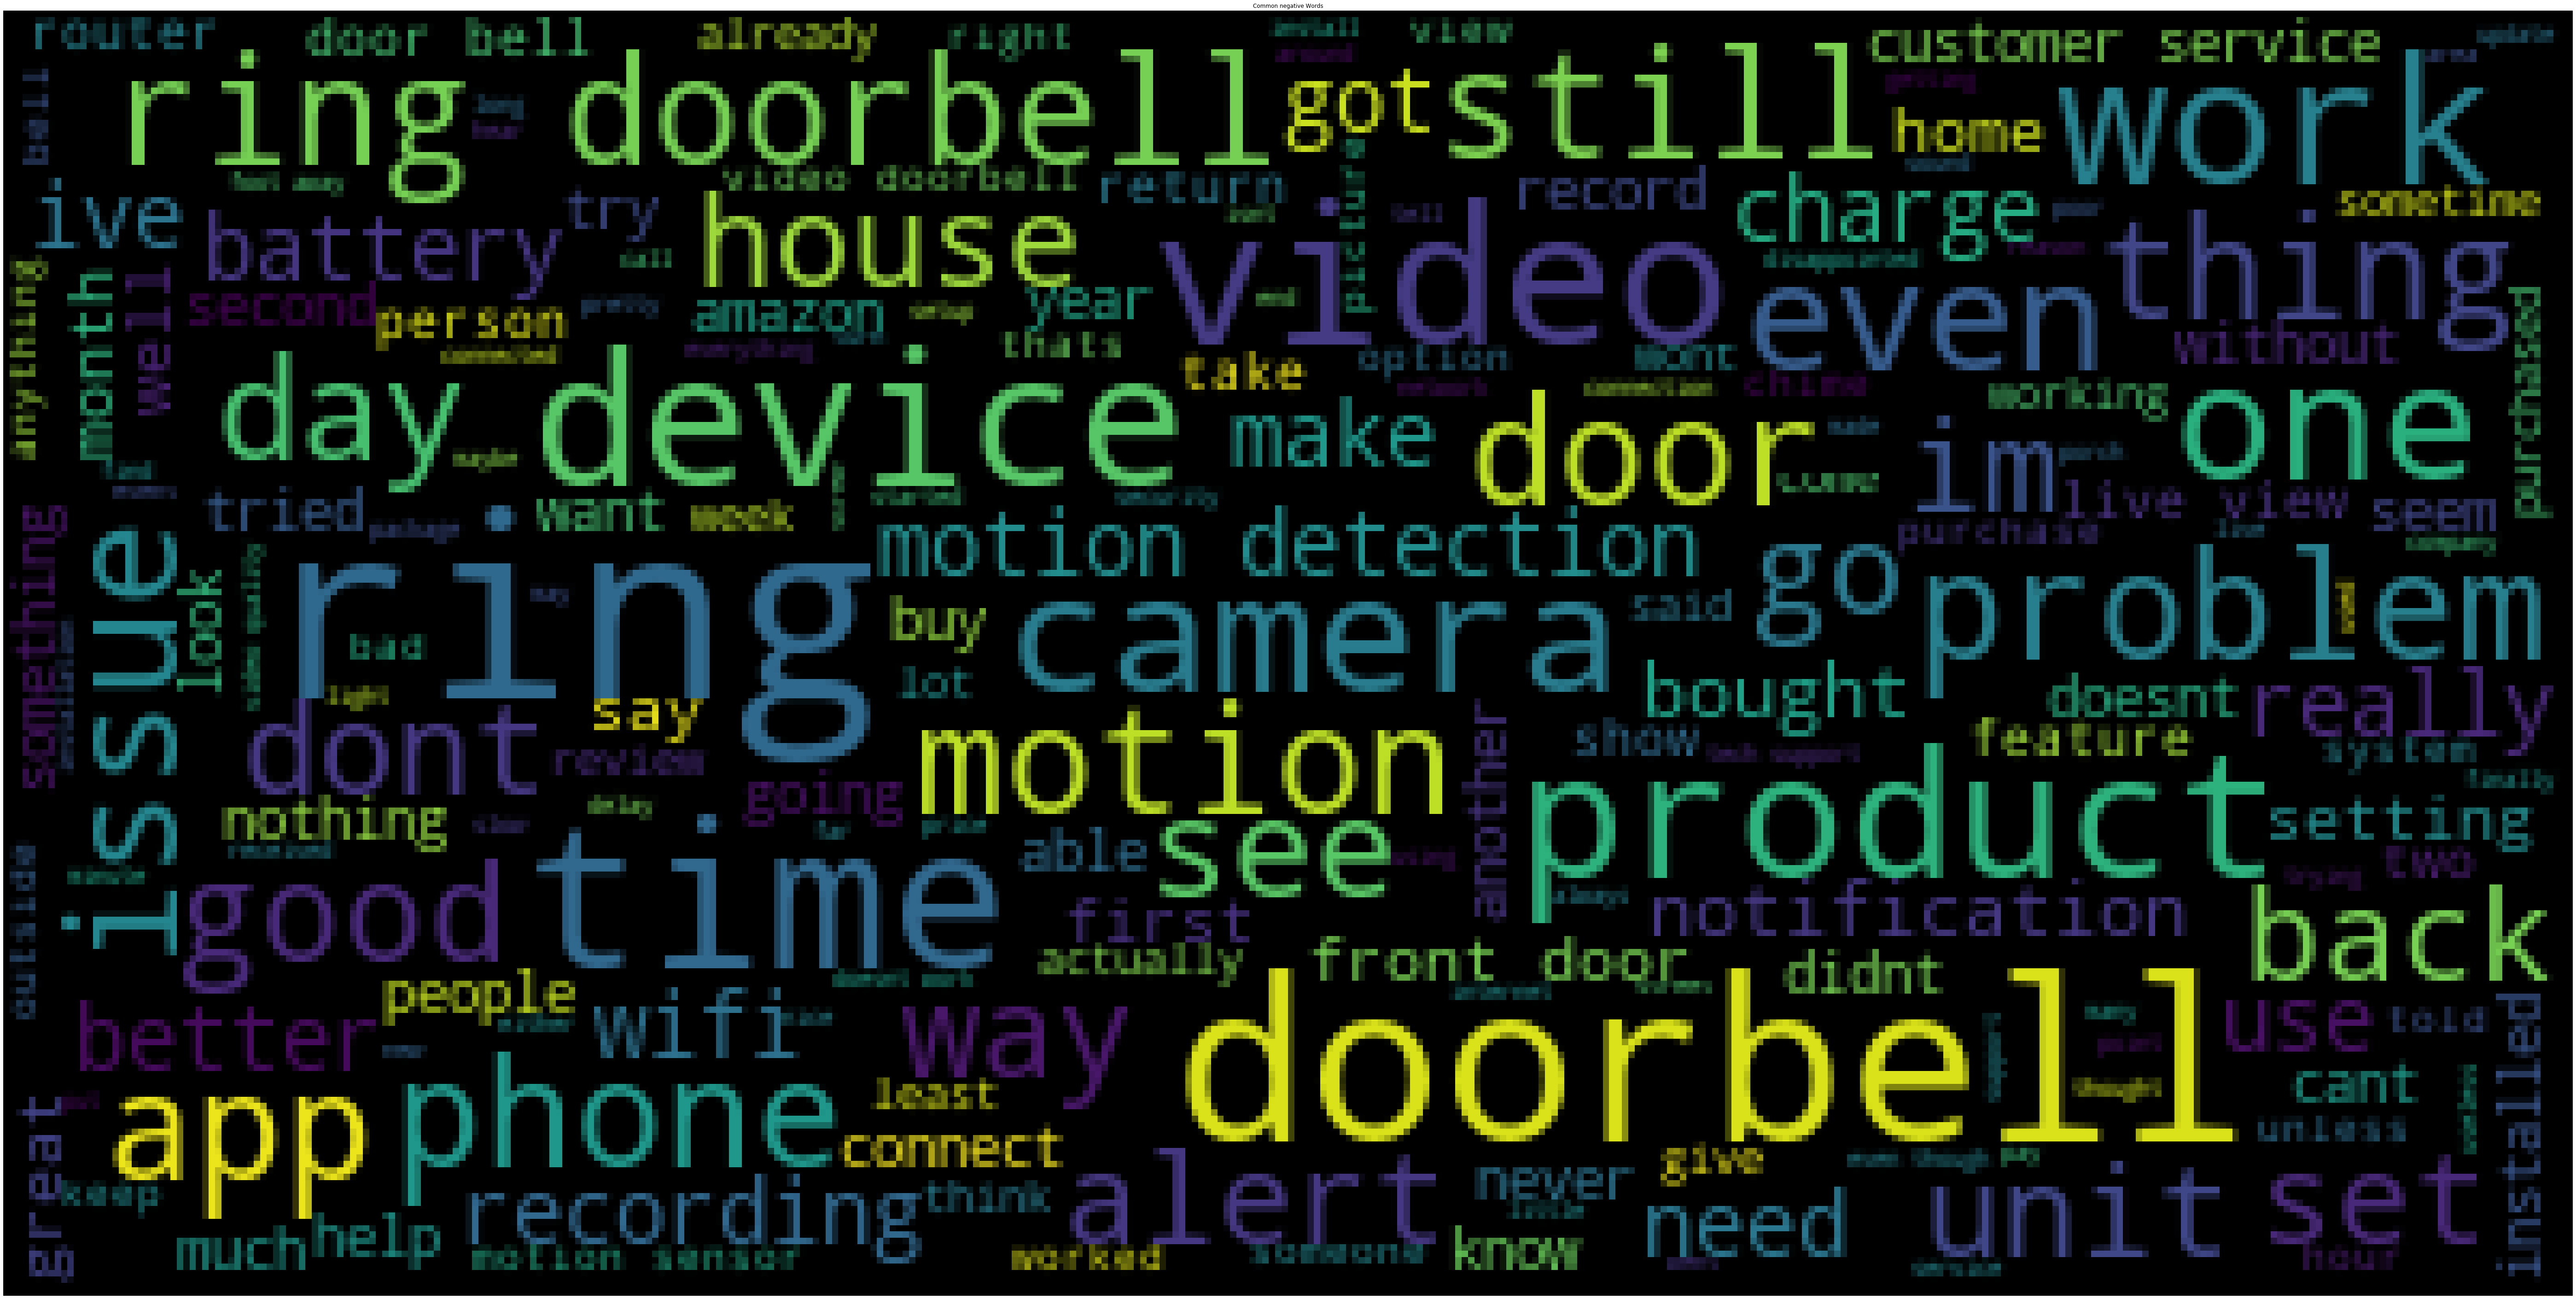

In [17]:
#Common negative Words
wc(negative_data['clean_Review'],'Common negative Words' ) 

In [18]:
#define X,y for the model
X=data['clean_Review']
y=data['class']
from sklearn.model_selection import StratifiedShuffleSplit
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state = 0)
print(len(X_train), len(X_test))


2496 624


In [19]:
# CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train) 
X_train_counts.shape

(2496, 12499)

In [23]:
# tfidf
tfidf_transformer = TfidfTransformer(use_idf=False)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(2496, 12499)

In [24]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
clf_multiNB_pipe = Pipeline([("vect", CountVectorizer()), ("tfidf", TfidfTransformer()), ("clf_nominalNB", MultinomialNB())])
clf_multiNB_pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf_nominalNB',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [25]:
predictedMultiNB = clf_multiNB_pipe.predict(X_test)
np.mean(predictedMultiNB == y_test)

0.8221153846153846

In [26]:
#Logistic Regression Classifier

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
clf_logReg_pipe = Pipeline([("vect", CountVectorizer()), ("tfidf", TfidfTransformer()), ("clf_logReg", LogisticRegression())])
clf_logReg_pipe.fit(X_train, y_train)

import numpy as np
predictedLogReg = clf_logReg_pipe.predict(X_test)
np.mean(predictedLogReg == y_test)

0.8349358974358975

In [27]:
#Support Vector Machine Classifier

from sklearn.svm import LinearSVC
clf_linearSVC_pipe = Pipeline([("vect", CountVectorizer()), ("tfidf", TfidfTransformer()), ("clf_linearSVC", LinearSVC())])
clf_linearSVC_pipe.fit(X_train, y_train)

predictedLinearSVC = clf_linearSVC_pipe.predict(X_test)
np.mean(predictedLinearSVC == y_test)

0.8477564102564102

In [28]:
text="Ring is an attractively designed device that appears to be well made. The physical installation was easy. The package included clear instructions for mounting on most common surfaces and tools and fasteners required. Installation took me less than 10 minutes. If you're mounting onto a hard surface like stucco or brick a masonry drill bit was included. Network installation took longer. For some reason I had to go through the installation process several times to get the device to work with both of our i phones simultaneously but everything did eventually connect. Picture quality is surprisingly good. Field of view is wide. In most circumstances sound quality is very good. I believe the limiting factor is cell connection where we were not Ring device quality. We have motion sensitivity turned off so we don't get notified every time someone goes in or out the front door so I can't report on that.For some reason connection to both phones is inconsistent. It may ring on one phone but not the other. As far as we know, in every case one of our phones rang. If we didn't have ring we'd have gotten nothing so I'm not dissatisfied.We have been able  the door while on the highway in the middle of the California desert, which is cool.Overall I'm satisfied with the device and would recommend it, but don't expect 100% perfection."
predicted=clf_linearSVC_pipe.predict([text])
if predicted[0] == 1 :
    print("This is positive sentiment")
else:
    print("This is negative sentiment")

This is positive sentiment


Conclusion

•Based on the Data, 5 rating is the most rating found, since there are 1000 review with 5 rating .

•The Latest Profiles that have Top rating are(Tammy Matchett, Barbara D,KTC,Overcomer98,Wayne).So, we recommend to buy from these Profiles.

•The Latest Profiles that have Down rating are(Michael, scott11699,Helen,Robert McKnight,duck). So, we recommend to don't buy from these Profiles.

•The review  Word Count Distribution range from about 5 to 450.

•When we plot Rating during mounths of years, we found that :  

 _Every year have more reviews than another
 
 _2019 have more rating numbers
 
 _Every year Between June and August high number of rating


In [ ]:
c = CountVectorizer(stop_words = 'english')

def text_fit(X, y, model,clf_model,coef_show=1):
    
    X_c = model.fit_transform(X)
    print('# features: {}'.format(X_c.shape[1]))
    X_train, X_test, y_train, y_test = train_test_split(X_c, y, random_state=0)
    print('# train records: {}'.format(X_train.shape[0]))
    print('# test records: {}'.format(X_test.shape[0]))
    clf = clf_model.fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    print ('Model Accuracy: {}'.format(acc))
    
    if coef_show == 1: 
        w = model.get_feature_names()
        coef = clf.coef_.tolist()[0]
        coeff_df = pd.DataFrame({'Word' : w, 'Coefficient' : coef})
        coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
        print('')
        print('-Top 20 positive-')
        print(coeff_df.head(20).to_string(index=False))
        print('')
        print('-Top 20 negative-')        
        print(coeff_df.tail(20).to_string(index=False))
    
    
text_fit(X, y, c, LogisticRegression())